<a href="https://colab.research.google.com/github/k-kotera/Jupyter_Implementations_ML/blob/master/OneClassSVM_by_GradientDescentMethod(tensorflow).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OneClassSVM by Gradient descent method

OneClassSVMの目的関数は次のように定式化される．

$\min \quad \|W\|^2 - b + C \sum_{i = 1}^N max(0,-f(x))$

識別関数は

$f(x) = Wx-b$

$x→Φ(x)$の写像を考えると，リプレゼンターの定理より，

$W = \sum_{i = 1}^N a_iΦ(x_i) $

と置き換えられるので，カーネル関数

$K(x_i,x_j) =  Φ(x_i)Φ(x_j)$

を用いて

$\min \quad \sum_{i = 1}^N\sum_{j = 1}^N a_i a_j K(x_i,x_j)  - b + C \sum_{i = 1}^N max(0,-f(x_i))$

$f(x) = \sum_{j = 1}^N a_j K(x_j,x) - b$



In [0]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn import datasets
from tensorflow.python.framework import ops
ops.reset_default_graph()

In [0]:
# Create graph
sess = tf.Session()

# Generate non-lnear data
(x_vals, y_vals) = datasets.make_circles(n_samples=350*2, factor=.5, noise=.1)
y_vals = np.array([1 if y==1 else -1 for y in y_vals])
class1_x = [x[0] for i,x in enumerate(x_vals) if y_vals[i]==1]
class1_y = [x[1] for i,x in enumerate(x_vals) if y_vals[i]==1]
class2_x = [x[0] for i,x in enumerate(x_vals) if y_vals[i]==-1]
class2_y = [x[1] for i,x in enumerate(x_vals) if y_vals[i]==-1]

# Declare batch size
batch_size = 350

x_vals_0 = x_vals[y_vals==1]

In [0]:
# Initialize placeholders
x_data = tf.placeholder(shape=[None, 2], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)
prediction_grid = tf.placeholder(shape=[None, 2], dtype=tf.float32)

In [0]:
# Create variables for svm
a = tf.Variable(tf.zeros(shape=[1,batch_size]))
b = tf.Variable(0.0)

In [0]:
# Gaussian (RBF) kernel
gamma = tf.constant(-10.0)
dist = tf.reduce_sum(tf.square(x_data), 1)
dist = tf.reshape(dist, [-1,1])
sq_dists = tf.add(tf.subtract(dist, tf.multiply(2., tf.matmul(x_data, tf.transpose(x_data)))), tf.transpose(dist))
my_kernel = tf.exp(tf.multiply(gamma, sq_dists))

In [0]:
# Define Loss Function
a_vec_cross = tf.matmul(tf.transpose(a), a)
first_term = tf.reduce_sum(a_vec_cross * my_kernel)

representer = tf.reshape(tf.matmul(a, my_kernel),(-1,1))
second_term = tf.reduce_mean( tf.maximum(0., b - representer))

loss = first_term + 10.0*second_term - b

In [0]:
# Gaussian (RBF) prediction kernel
rA = tf.reshape(tf.reduce_sum(tf.square(x_data), 1),[-1,1])
rB = tf.reshape(tf.reduce_sum(tf.square(prediction_grid), 1),[-1,1])
pred_sq_dist = tf.add(tf.subtract(rA, tf.multiply(2., tf.matmul(x_data, tf.transpose(prediction_grid)))), tf.transpose(rB))
pred_kernel = tf.exp(tf.multiply(gamma, pred_sq_dist))

In [0]:
prediction_output = tf.matmul(a, pred_kernel) - b #f(x) = ΣaK(x,x) - b
prediction = tf.sign(prediction_output)
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(prediction), tf.squeeze(y_target)), tf.float32))

In [0]:
# Declare optimizer
my_opt = tf.train.GradientDescentOptimizer(0.001)
train_step = my_opt.minimize(loss)

# Initialize variables
init = tf.global_variables_initializer()
sess.run(init)

In [10]:
# Training loop
loss_vec = []
batch_accuracy = []
for i in range(1000):

    sess.run(train_step, feed_dict={x_data: x_vals_0})
    
    temp_loss = sess.run(loss, feed_dict={x_data: x_vals_0})
    loss_vec.append(temp_loss)
    
    acc_temp = sess.run(accuracy, feed_dict={x_data: x_vals_0,
                                             y_target: y_vals.reshape(-1,1),
                                             prediction_grid:x_vals})
    batch_accuracy.append(acc_temp)
    
    if (i+1)%200==0:
        print('Step #' + str(i+1))
        print('Loss = ' + str(temp_loss))
        print('acc = ' + str(acc_temp))

Step #200
Loss = -0.024956515
acc = 0.9342857
Step #400
Loss = -0.026081365
acc = 0.92285717
Step #600
Loss = -0.022072654
acc = 0.98714286
Step #800
Loss = -0.0172675
acc = 0.98
Step #1000
Loss = -0.025314277
acc = 0.97


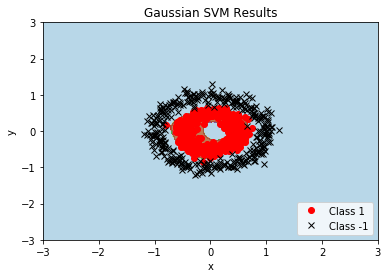

In [11]:
# Create a mesh to plot points in
x_min, x_max = x_vals[:, 0].min() - 3, x_vals[:, 0].max() + 3
y_min, y_max = x_vals[:, 1].min() - 3, x_vals[:, 1].max() + 3
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))
grid_points = np.c_[xx.ravel(), yy.ravel()]
[grid_predictions] = sess.run(prediction, feed_dict={x_data: x_vals_0,
                                                   prediction_grid: grid_points})
grid_predictions = grid_predictions.reshape(xx.shape)

# Plot points and grid
plt.contourf(xx, yy, grid_predictions, cmap=plt.cm.Paired, alpha=0.8)
plt.plot(class1_x, class1_y, 'ro', label='Class 1')
plt.plot(class2_x, class2_y, 'kx', label='Class -1')
plt.title('Gaussian SVM Results')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='lower right')
plt.ylim([-3, 3])
plt.xlim([-3, 3])
plt.show()

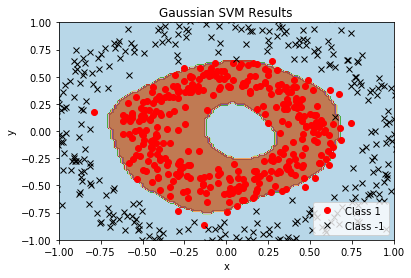

In [12]:
#Zoom
plt.contourf(xx, yy, grid_predictions, cmap=plt.cm.Paired, alpha=0.8)
plt.plot(class1_x, class1_y, 'ro', label='Class 1')
plt.plot(class2_x, class2_y, 'kx', label='Class -1')
plt.title('Gaussian SVM Results')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='lower right')
plt.ylim([-1, 1])
plt.xlim([-1, 1])
plt.show()